In [1]:
import numpy as np
import torch 
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
import torchvision
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import os
import random
import copy
from collections import defaultdict
import time
import pickle

In [2]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.8/208.8 kB 931.6 kB/s eta 0:00:00a 0:00:01


In [4]:
from torchattacks import *

## 1. Data Preprocessing

In [5]:
def preprocessing(main_folder_path):
    # list of folders in the main folder
    listdir = sorted(os.listdir(main_folder_path))
    
    # Image Transformation
#     mean = [0.485, 0.456, 0.406] # mean of image tensor
#     std = [0.229, 0.224, 0.225]  # standard devisation of image tensor
#     normalize_stat = (mean, std)
#     size = 224

#     transform = T.Compose([
#         T.Resize(size),
#         T.CenterCrop(size),
#         T.ToTensor(),
#         T.Normalize(*normalize_stat)
#     ])

#     dataset = ImageFolder(main_folder_path, transform=transform)
    dataset = ImageFolder(main_folder_path)
    classes = dataset.classes

    return dataset, classes

In [6]:
main_folder_path = '../input/pins-face-recognition/105_classes_pins_dataset'
dataset, classes = preprocessing(main_folder_path)

print("Total dataset size: ", len(dataset))
print("Number of classes: ", len(classes))

Total dataset size:  17534
Number of classes:  105


In [7]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 17534
    Root location: ../input/pins-face-recognition/105_classes_pins_dataset


In [8]:
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [9]:
def my_adjust_brightness(brightness_factor):
    def _func(img):
        return  TF.adjust_brightness(img, brightness_factor)
    return _func

In [10]:
def my_erase(i, j, h, w, erase_value):
    def _func(img):
        return  TF.erase(img, i, j, h, w, erase_value)
    return _func

In [11]:
def dataloader(i, j, h, w, erase_value, brightness_factor, orig_pixel, downgrade_pixel, downgrade_client_count, dataset, classes, train_batch_size, test_batch_size, num_clients):
    # torch.manual_seed(42)
    
    # 70% to 30% train to test
    num_val = int(len(dataset) * 0.3)
    num_train = len(dataset) - num_val
    
    # 1. Train and Validation Data
    train_data, test_data = random_split(dataset, [num_train, num_val])
    
    # save train_data size (n)
    n = len(train_data)
    
    # Partition data for federated learning
    train_loader_list = []
    
    # nk / n list
    nk_n_list = []
    
    # Client ID: corresponding train_loader
    client_loader_dict = {}
    
    # Split train dataset
    total_train_size = len(train_data)
    examples_per_client = total_train_size // num_clients
    client_datasets = random_split(train_data, [min(i + examples_per_client, 
               total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
    
    # Remove the left over (4)
    client_datasets = client_datasets[:num_clients]
    
    # Select the client_id to set 3x128x128 pixel
    client_id_list = [i for i in range(num_clients)]
    downgrade_selected = random.sample(client_id_list, k=downgrade_client_count)
    
    for idx, cli_data in enumerate(client_datasets):
        # Image Transformation
        mean = [0.485, 0.456, 0.406] # mean of image tensor
        std = [0.229, 0.224, 0.225]  # standard devisation of image tensor
        normalize_stat = (mean, std)
        
        # Assign specific resolution to specific client_id
        if idx in downgrade_selected:
            size = downgrade_pixel
            # brightness_factor = 0.15
            transforms = T.Compose([
                T.Resize(size),
                T.CenterCrop(size),
                T.ToTensor(),
                T.Normalize(*normalize_stat),
                # my_erase(i, j, h, w, erase_value)
                my_adjust_brightness(brightness_factor)
            ])
        else:
            size = orig_pixel
            transforms = T.Compose([
                T.Resize(size),
                T.CenterCrop(size),
                T.ToTensor(),
                T.Normalize(*normalize_stat)
            ])
        
        new_cli_data = DatasetFromSubset(cli_data, transform=transforms)
        
        # Save nk / n
        nk_n = len(new_cli_data) / len(train_data)
        nk_n_list.append(nk_n)
        
        train_loader = DataLoader(new_cli_data, batch_size=train_batch_size, shuffle=True, pin_memory=False, num_workers=3)
        train_loader_list.append(train_loader)
        client_loader_dict[idx] = train_loader
        
        print(f"Client_id {idx} data size: {len(new_cli_data)}")
    
    print("")
    print("Modified client_id: ", downgrade_selected)

    # Train and Validation Dataloader
    loader_idx = 0
    for cli_id, loader in client_loader_dict.items():
        client_loader_dict[cli_id] = train_loader_list[loader_idx]
        loader_idx += 1
        print(f"Client_id {cli_id} pixel size: {(iter(loader).next()[0]).size()}")
    
    
    
    # Create test data
    test_orig_transforms = T.Compose([T.Resize(orig_pixel),
                                      T.CenterCrop(orig_pixel),
                                      T.ToTensor(),
                                      T.Normalize(*normalize_stat)
                                     ])
    
    test_bright_transforms = T.Compose([T.Resize(orig_pixel),
                                          T.CenterCrop(orig_pixel),
                                          T.ToTensor(),
                                          T.Normalize(*normalize_stat),
                                          # my_erase(i, j, h, w, erase_value)
                                          my_adjust_brightness(2.30)
                                         ])
    
    test_dark_transforms = T.Compose([T.Resize(orig_pixel),
                                      T.CenterCrop(orig_pixel),
                                      T.ToTensor(),
                                      T.Normalize(*normalize_stat),
                                      # my_erase(i, j, h, w, erase_value)
                                      my_adjust_brightness(0.15)
                                     ])
    
    
    # Augment the mixed test data 
    # Combination of different brightness / pixel / cropped
    orig_test_data = DatasetFromSubset(test_data, transform=test_orig_transforms)
    bright_test_data = DatasetFromSubset(test_data, transform=test_bright_transforms)
    dark_test_data = DatasetFromSubset(test_data, transform=test_dark_transforms)
    
    orig_bright_test_data = orig_test_data + bright_test_data
    orig_dark_test_data = orig_test_data + dark_test_data
    orig_bright_dark_test_data = orig_test_data + dark_test_data + bright_test_data
    
    test_loader = DataLoader(orig_test_data, batch_size=test_batch_size, shuffle=True, pin_memory=False, num_workers=3)
    orig_bright_test_loader = DataLoader(orig_bright_test_data, batch_size=test_batch_size, shuffle=True, pin_memory=False, num_workers=3)
    orig_dark_test_loader = DataLoader(orig_dark_test_data, batch_size=test_batch_size, shuffle=True, pin_memory=False, num_workers=3)
    orig_bright_dark_test_loader = DataLoader(orig_bright_dark_test_data, batch_size=test_batch_size, shuffle=True, pin_memory=False, num_workers=3)
    
    return train_loader_list, client_loader_dict, test_loader, orig_bright_test_loader, orig_dark_test_loader, orig_bright_dark_test_loader, test_data, nk_n_list

In [12]:
def denormal(image):
    image = image.numpy().transpose(1, 2, 0)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def denormalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # 3, H, W, B
    ten = x.clone().permute(1, 2, 3, 0)
    for t, m, s in zip(ten, mean, std):
        t.mul_(s).add_(m)
    
    # B, 3, H, W
    return torch.clamp(ten, 0, 1).permute(3, 0, 1, 2)

In [13]:
# idx = 1
# image, label = dataset[idx]

# print("Size of first image: ", image.size
# plt.imshow(denormal(image))
# plt.title(dataset.classes[label])
# plt.axis('off')

## imshow

In [14]:
def imshow(image, label, knn_bool=False):
    label = str(label)
    plt.figure(figsize=(5, 5))
    plt.title("label: " + label)
    
    # for PIL and Torch Tensor
    if knn_bool is False: 
        print(image.shape)
        image = image.permute(1, 2, 0)
        plt.imshow(image)
        plt.show()
    
    # for KNN
    else:
        plt.imshow(image)
        plt.show()

In [15]:
downgrade_client_count = 2
downgrade_pixel = 224
orig_pixel = 224

brightness_factor = 0.15

# Pixel Erasing Section
i = 0
j = 0
h = 0
w = 0
erase_value = 1

train_loader_list, client_loader_dict, test_loader, orig_bright_test_loader, orig_dark_test_loader, orig_bright_dark_test_loader, test_data, nk_n_list = dataloader(i, j, h, w, erase_value, brightness_factor, orig_pixel, downgrade_pixel, downgrade_client_count, dataset, classes, 64, 64, 5)

Client_id 0 data size: 2454
Client_id 1 data size: 2454
Client_id 2 data size: 2454
Client_id 3 data size: 2454
Client_id 4 data size: 2454

Modified client_id:  [3, 1]


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Client_id 0 pixel size: torch.Size([64, 3, 224, 224])
Client_id 1 pixel size: torch.Size([64, 3, 224, 224])
Client_id 2 pixel size: torch.Size([64, 3, 224, 224])
Client_id 3 pixel size: torch.Size([64, 3, 224, 224])
Client_id 4 pixel size: torch.Size([64, 3, 224, 224])


In [16]:
org_img, orig_label = (iter(client_loader_dict[1]).next())
mod_img, mod_label = (iter(client_loader_dict[2]).next())

Text(0.5, 1.0, 'pins_elizabeth olsen')

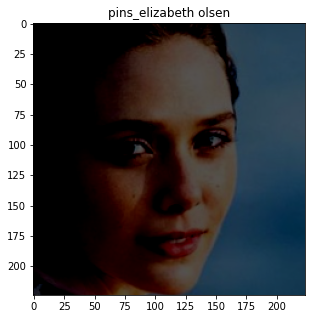

In [17]:
orig_image, label = org_img[0], orig_label[0]

plt.figure(figsize=(5, 5))
plt.imshow(orig_image.numpy().transpose(1, 2, 0))
plt.title(dataset.classes[label])

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Text(0.5, 1.0, 'pins_elizabeth olsen')

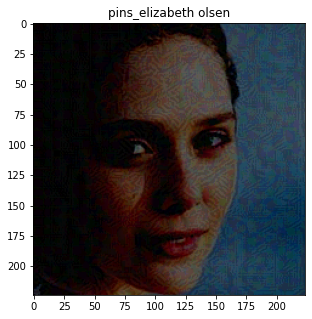

In [18]:
model = torchvision.models.alexnet(pretrained=True)
atk = FGSM(model, eps=8/255)
adv_images = atk(org_img, orig_label)

plt.figure(figsize=(5, 5))
plt.imshow(adv_images[0].numpy().transpose(1, 2, 0))
plt.title(dataset.classes[label])

Text(0.5, 1.0, 'pins_elizabeth olsen')

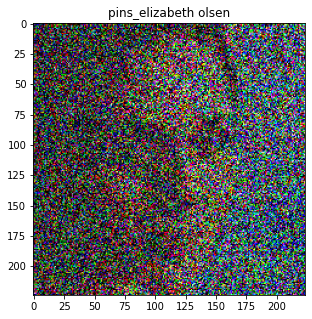

In [19]:
model = torchvision.models.alexnet(pretrained=True)
atk = FFGSM(model, eps=0.9)
adv_images = atk(org_img, orig_label)

plt.figure(figsize=(5, 5))
plt.imshow(adv_images[0].numpy().transpose(1, 2, 0))
plt.title(dataset.classes[label])

Text(0.5, 1.0, 'pins_elizabeth olsen')

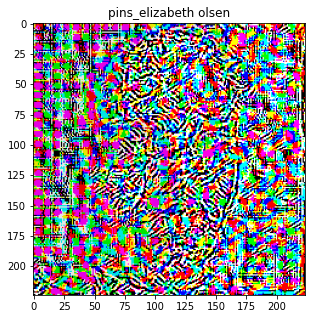

In [20]:
model = torchvision.models.alexnet(pretrained=True)
atk = FGSM(model, eps=0.9)
adv_images = atk(org_img, orig_label)

plt.figure(figsize=(5, 5))
plt.imshow(adv_images[0].numpy().transpose(1, 2, 0))
plt.title(dataset.classes[label])

FFGSM(model_name=AlexNet, device=cpu, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)


Text(0.5, 1.0, 'pins_elizabeth olsen')

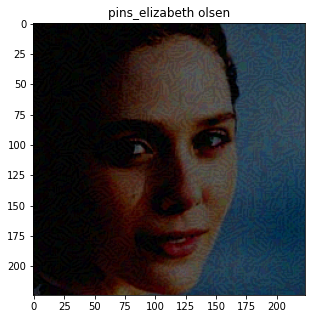

In [21]:
model = torchvision.models.alexnet(pretrained=True)
atk = FFGSM(model, eps=8/255, alpha=10/255)
adv_images = atk(org_img, orig_label)

print(atk)
plt.figure(figsize=(5, 5))
plt.imshow(adv_images[0].numpy().transpose(1, 2, 0))
plt.title(dataset.classes[label])

Square(model_name=AlexNet, device=cpu, norm=Linf, n_queries=2000, eps=0.03137254901960784, p_init=0.8, n_restarts=1, seed=0, verbose=False, loss=ce, rescale_schedule=True, orig_dim=[3, 224, 224], ndims=3, attack_mode=default, return_type=float)


Text(0.5, 1.0, 'pins_elizabeth olsen')

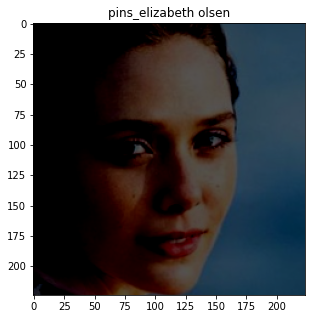

In [22]:
model = torchvision.models.alexnet(pretrained=True)
atk = Square(model, eps=8/255, n_queries=2000, loss='ce')
adv_images = atk(org_img, orig_label)

print(atk)
plt.figure(figsize=(5, 5))
plt.imshow(adv_images[0].numpy().transpose(1, 2, 0))
plt.title(dataset.classes[label])

Size of augmented test_loader:  247
torch.Size([3, 224, 224])


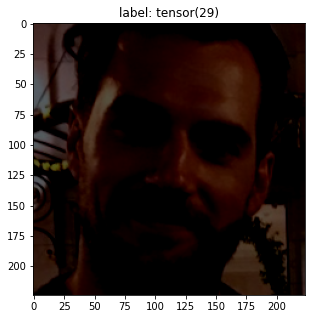

In [23]:
print("Size of augmented test_loader: ", len(orig_bright_dark_test_loader))
test_img, test_label = (iter(orig_bright_dark_test_loader)).next()
test_image, label = test_img[0], test_label[0]
imshow(test_image, label)

torch.Size([3, 224, 224])


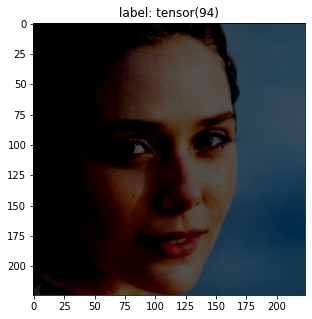

In [24]:
orig_image, label = org_img[0], orig_label[0]
imshow(orig_image, label)

torch.Size([3, 224, 224])


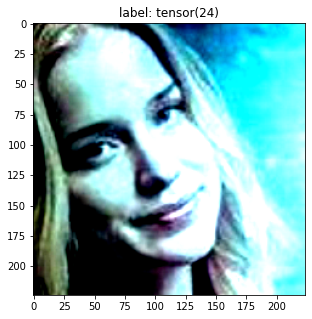

In [25]:
mod_image, label = mod_img[0], mod_label[0]
imshow(mod_image , label)

## 2. Model

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
from glob import glob
from tqdm.notebook import tqdm

In [27]:
class black_box_model(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained mode
        self.resnet34 = models.resnet34(True)
        self.features = nn.Sequential(*list(self.resnet34.children())[:-1])
        # Replace last layer
        self.classifier = nn.Sequential(nn.Flatten(),
                                         nn.Linear(self.resnet34.fc.in_features, num_classes))

    def forward(self, x):
        x = self.features(x)
        y = self.classifier(x)
        return y
    
    def summary(self, input_size):
        return summary(self, input_size)

In [28]:
# class white_box_model(nn.Module):
#     def __init__(self, num_classes, dropout, pretrained=True):
#         super().__init__()
#         # Use a pretrained model
#         self.dropout = dropout
#         self.alexnet = models.alexnet(True)
#         self.features = nn.Sequential(*list(self.alexnet.children())[:-1])
        
#         # Replace last layer
#         self.classifier = nn.Sequential(
#             nn.Dropout(p=self.dropout),
#             nn.Linear(6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=self.dropout),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         y = self.classifier(x)
#         return y
    
#     def summary(self, input_size):
#         return summary(self, input_size)

In [29]:
# class white_box_model(nn.Module):
#     def __init__(self, num_classes, pretrained=True):
#         super().__init__()
#         # Use a pretrained model
#         self.resnet50 = models.resnet50(True)
#         self.features = nn.Sequential(*list(self.resnet50.children())[:-1])
#         # Replace last layer
#         self.classifier = nn.Sequential(nn.Flatten(),
#                                          nn.Linear(self.resnet50.fc.in_features, num_classes))

#     def forward(self, x):
#         x = self.features(x)
#         y = self.classifier(x)
#         return y
    
#     def summary(self, input_size):
#         return summary(self, input_size)

In [30]:
# models.resnet34(True).fc.in_features

In [31]:
main_folder_path = '../input/pins-face-recognition/105_classes_pins_dataset'
dataset, classes = preprocessing(main_folder_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(classes)

global_model = black_box_model(num_classes=num_classes).to(device)
# global_model.summary((3, 32, 32))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [32]:
# main_folder_path = '../input/pins-face-recognition/105_classes_pins_dataset'
# dataset, classes = preprocessing(main_folder_path)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# num_classes = len(classes)

# model = white_box_model(num_classes=num_classes).to(device)
# # model.summary((3, 96, 96))

## 3. Federated Learning

In [33]:
# # Federated Averaging Algorithm (Non-IID)
# def fedAvg(w, nk_n_list, client_id_selected):
    
#     print("")
#     print("Averaging client_id list: ", client_id_selected)
    
#     first_id = client_id_selected[0]
#     w_avg = copy.deepcopy(w[first_id])
    
#     # Update first weight parameter
#     for k in w_avg.keys():
#         nk_n = nk_n_list[first_id]
#         w_avg[k] = w_avg[k] + (nk_n * w[first_id][k])
    
#     # Remove the updated id weight
#     client_id_selected.remove(first_id)
    
#     print("After removing first index: ", client_id_selected)
#     print("")
    
#     # Use selected client's weight parameters
#     for k in w_avg.keys():
#         for i in client_id_selected: 
#             nk_n = nk_n_list[i]
#             w_avg[k] = w_avg[k] + (nk_n * w[i][k])
        
#         w_avg[k] = torch.div(w_avg[k], len(w))
    
#     return w_avg

In [34]:
# FedAvg (iid-setting)
from collections import OrderedDict

def fedAvg(client_model_list, nk_n_list):
    new_params = OrderedDict()
    
    n = len(client_model_list)  # number of clients
    
    for client_model in client_model_list:
        local_param = client_model.state_dict()  # get current parameters of one client
        for k, v in local_param.items():
            new_params[k] = new_params.get(k, 0) + v / n
    
    return new_params

## 4. Clean Training and Evaluation

In [35]:
pip install torchattacks

Note: you may need to restart the kernel to use updated packages.


In [36]:
from torchattacks import *

In [37]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

# Code Referance: https://www.kaggle.com/code/pezhmansamadi/facerecognition-torch-resnet34

def local_train(clean_train_batch_ratio, atk, attack_id_selected, white_model, client_id, e, local_epochs, local_model, train_loader, device, criterion, optimizer):
    torch.cuda.empty_cache()
    local_model.train(True)
    torch.set_grad_enabled(True)
    
    if client_id in attack_id_selected:
        # Create adversarial example
        print(atk)
        print("Adversarial Training on current device")
    
    total = 0
    correct = 0
    local_loss = 0.0
    local_acc = 0
    
    tq_batch = tqdm(train_loader, total=len(train_loader))
    for idx, (images, labels) in enumerate(tq_batch):
        images = images.to(device)
        labels = labels.to(device)
        
        ratio = int(len(train_loader) * clean_train_batch_ratio)
        
        # Attack if current id is the selected id
        if (client_id in attack_id_selected) and (idx >= ratio):
            # print("Half way")
            # Create adversarial example
            images = atk(images, labels)
            
        optimizer.zero_grad()
        outs = local_model(images)
        _, preds = torch.max(outs, 1)
        
        # outs = torch.exp(outs)
        loss = criterion(outs, labels)
        loss.backward()
        optimizer.step()
        local_loss += loss.item()
        
        total += labels.size(0)
        correct += (preds == labels).sum()
        local_acc += float(correct) / total
        
        tq_batch.set_description(f'Local Epoch [{e + 1}/{local_epochs}]')
        tq_batch.set_postfix_str('Local loss = {:.4f} ; Local acc = {:.4f} '.format(loss.item(), float(correct) / total))
    
    # Average loss and acc of the training batch
    local_acc = local_acc / len(train_loader)
    local_loss = local_loss / len(train_loader)
    local_w = local_model.state_dict()

    return local_model, local_loss, local_w, local_acc

def global_evaluate(global_model, test_loader, criterion, device):
    torch.cuda.empty_cache()
    global_model.eval()
    
    total = 0
    glob_loss = 0
    glob_acc = 0
    correct = 0
    
    tq_batch = tqdm(test_loader, total=len(test_loader), leave=False)
    for images, labels in tq_batch:
        images = images.to(device)
        labels = labels.to(device)

        outputs = global_model(images)
        loss = criterion(outputs, labels)
        glob_loss += loss.item()
        
        _, preds = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (preds == labels).sum()
        
        glob_acc += float(correct) / total
        batch_acc = float(correct) / total
        
        tq_batch.set_postfix_str('Global loss = {:.4f} ; Global acc = {:.4f} '.format(loss.item(), batch_acc))
    
    # Average global loss and acc of the batch
    glob_loss = glob_loss / len(test_loader)
    glob_acc = glob_acc / len(test_loader)

    return glob_acc, glob_loss

In [38]:
def robust_evaluate(atk, white_model, global_model, test_loader, criterion, device):
    torch.cuda.empty_cache()
    global_model.eval()
    
    total = 0
    robust_loss = 0
    robust_acc = 0
    correct = 0
    
    tq_batch = tqdm(test_loader, total=len(test_loader), leave=False)
    for images, labels in tq_batch:
        images = images.to(device)
        labels = labels.to(device)
        
        # Create adversarial example
        images = atk(images, labels)

        outputs = global_model(images)
        loss = criterion(outputs, labels)
        robust_loss += loss.item()
        
        _, preds = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (preds == labels).sum()
        
        robust_acc += float(correct) / total
        batch_acc = float(correct) / total
        
        tq_batch.set_postfix_str('Robust loss = {:.4f} ; Robust acc = {:.4f} '.format(loss.item(), batch_acc))
    
    # Average global loss and acc of the batch
    robust_loss = robust_loss / len(test_loader)
    robust_acc = robust_acc / len(test_loader)

    return robust_acc, robust_loss

In [39]:
def federated_learning(test_loader, clean_train_batch_ratio, num_attacks, white_model, num_selected, num_rounds, num_clients, num_local_epochs, global_model, client_model_list, client_loader_dict, device, nk_n_list):
    torch.cuda.empty_cache()
    
    print("Test loader length: ", len(test_loader))
    
    id_loss_dict = defaultdict(list)
    id_acc_dict = defaultdict(list)
    update_count_dict = {}
    adv_train_dict = {}
    
    num_client_list = [i for i in range(num_clients)] # Total client id list
    
    #############################################
    # Method 2
#     attack_id_selected = random.sample(num_client_list, k=num_attacks) # Clients to be adversarially trained
#     print("Adversarial Training id selected: ", attack_id_selected)
#     for cli in attack_id_selected: 
#         adv_train_dict[cli] = 0
    #############################################    
    
    for _client in num_client_list:
        update_count_dict[_client] = 0
        # ***************************************
        # Method_1
        adv_train_dict[_client] = 0 
        # ***************************************

    
    local_w_list = [None for i in range(num_clients)]
    local_loss_list = [100 for i in range(num_clients)]
    
    glob_acc_list = []
    glob_loss_list = []
    robust_acc_list = []
    robust_loss_list = []
    
    criterion = nn.CrossEntropyLoss()
    
    # Black-box model setting
    # Use second party pre-trained model to create the adversarial example
#     atk = FGSM(white_model, eps=8/255)
    atk = FFGSM(white_model, eps=8/255, alpha=10/255) # *
#     atk = DeepFool(white_model, steps=100)
#     atk = Square(white_model, eps=8/255) # *
#     atk = PGD(white_model, eps=8/255, alpha=2/225, steps=10, random_start=True)
    
    # For each round
    start_time = time.time()
    for each_round in tqdm(range(num_rounds)):
        # Randomly selected client id "EACH ROUND"        
        # client_id_selected = num_client_list
        client_id_selected = random.sample(num_client_list, k=num_selected)   # Clients to be trained
        
        # ***************************************
        # Method_1
        attack_id_selected = random.sample(client_id_selected, k=num_attacks) # Clients to be adversarially trained (select within client to be trained)
        # ***************************************
        
        print("Selected client_id: ", client_id_selected)
        print("Adversarial Training id selected: ", attack_id_selected)
        
        # 1. Increase count for number of updates
        # 2. Increase count for adv_trained client id
        for _id in client_id_selected:
            update_count_dict[_id] += 1
            
            #############################################
#             # Method_2
#             if _id in attack_id_selected: 
#                 adv_train_dict[_id] += 1
            #############################################
        
        # ***************************************
        # Method_1
        for __id in attack_id_selected: 
            adv_train_dict[__id] += 1
        # ***************************************
        
        # For each client
        start_time = time.time()
        client_count = 1
        for client_id in tqdm(client_id_selected):
            print("")
            print(f"Updating [client_id]: {client_id}")
            print("")
            local_model = client_model_list[client_id]
            local_dataloader = client_loader_dict[client_id]
            
            learning_rate = 0.05
            optimizer = torch.optim.SGD(local_model.parameters(), lr=learning_rate)
            
            # For each local epoch for each client
            for e in tqdm(range(num_local_epochs)):
                # Train local client models

                local_updated_model, new_local_loss, local_w, local_acc = local_train(clean_train_batch_ratio,
                                                                                      atk,
                                                                                      attack_id_selected, 
                                                                                      white_model,
                                                                                      client_id,
                                                                                      e, 
                                                                                      num_local_epochs, 
                                                                                      local_model, 
                                                                                      local_dataloader, 
                                                                                      device, 
                                                                                      criterion, 
                                                                                      optimizer)
                current_loss = local_loss_list[client_id]
                
                # Save loss & acc for each client id
                id_loss_dict[client_id].append(new_local_loss)
                id_acc_dict[client_id].append(local_acc)
                
                # Append new local_loss and local_weight
                local_loss_list[client_id] = new_local_loss
                local_w_list[client_id] = local_w 
                
                print(f"[rounds]: {each_round + 1}/{num_rounds} - [client_count]: {client_count}/{num_selected} - [local_epoch]: {e+1}/{num_local_epochs} - [local_loss]: {new_local_loss} - [local_acc]: {local_acc*100}%")
            
            client_count += 1
            
        # Federaed Averaging
        # new_glob_w = fedAvg(local_w_list, nk_n_list, client_id_selected)
        new_glob_w = fedAvg(client_model_list, nk_n_list)
        global_model.load_state_dict(new_glob_w)
        
        # Send new global model back to clients
        print("")
        print(" ")
        print("Sending global model weight to local client models...")
        print("")
        for loc_model in client_model_list:
            loc_model.load_state_dict(new_glob_w)
        
        # Evaluate Global Model
        glob_acc, glob_loss = global_evaluate(global_model, test_loader, criterion, device)
        robust_acc, robust_loss = robust_evaluate(atk, white_model, global_model, test_loader, criterion, device)
        
        glob_acc_list.append(glob_acc*100)
        glob_loss_list.append(glob_loss)
        robust_acc_list.append(robust_acc*100)
        robust_loss_list.append(robust_loss)
        
        print("")
        print("*"*100)
        print("")
        print(f"[rounds]: {each_round + 1}/{num_rounds} - [global_loss]: {glob_loss} - [global_acc]: {glob_acc*100} %")
        print(f"[rounds]: {each_round + 1}/{num_rounds} - [robust_loss]: {robust_loss} - [robust_acc]: {robust_acc*100} %")
        print("")
        print("*"*100)
        print("")
    
    # Show number of updates for each client
    print("")
    for __id, count in update_count_dict.items():
        print("Client {} updated count: {}".format(__id, count))
    print("")
    
    # Adversarial Training Count
    print("")
    for _id, count in adv_train_dict.items():
        print("Client {} adversarial training count: {}".format(_id, count))
    print("")
    
    # Total time taken
    print("Time taken = {:.4f} minutes".format((time.time() - start_time) / 60))
    
    # Save Current Model
    pickle.dump(global_model, open('global_model.pkl', 'wb'))
    
    return global_model, glob_acc_list, robust_acc_list, glob_loss_list, robust_loss_list, id_loss_dict

In [40]:
main_folder_path = '../input/pins-face-recognition/105_classes_pins_dataset'
   
num_clients = 5
train_batch_size = 64
test_batch_size = 64

brightness_factor = 2.30   # brighter image
downgrade_pixel = 224      # reduced resolution size
orig_pixel = 224           # original resolution size
downgrade_client_count = 2 # No. of clients to reduce resolution

# Pixel Erasing Section (Cover Eyes)
i = 0
j = 0
h = 0
w = 0
erase_value = 1

dataset, classes = preprocessing(main_folder_path=main_folder_path)
train_loader_list, client_loader_dict, test_loader, orig_bright_test_loader, orig_dark_test_loader, orig_bright_dark_test_loader, test_data, nk_n_list = dataloader(
                                                                              i,
                                                                              j,
                                                                              h,
                                                                              w,
                                                                              erase_value,
                                                                              brightness_factor,
                                                                              orig_pixel,
                                                                              downgrade_pixel, 
                                                                              downgrade_client_count, 
                                                                              dataset, 
                                                                              classes, 
                                                                              train_batch_size, 
                                                                              test_batch_size, 
                                                                              num_clients)


print("Training Brightness Factor: ", brightness_factor)
print("")

for idx, dt in client_loader_dict.items():
    print(f'Client {idx} dataloader size: {len(dt)}')

print("")
print("Test dataloader size: ", len(test_loader))

Client_id 0 data size: 2454
Client_id 1 data size: 2454
Client_id 2 data size: 2454
Client_id 3 data size: 2454
Client_id 4 data size: 2454

Modified client_id:  [3, 2]
Client_id 0 pixel size: torch.Size([64, 3, 224, 224])
Client_id 1 pixel size: torch.Size([64, 3, 224, 224])
Client_id 2 pixel size: torch.Size([64, 3, 224, 224])
Client_id 3 pixel size: torch.Size([64, 3, 224, 224])
Client_id 4 pixel size: torch.Size([64, 3, 224, 224])
Training Brightness Factor:  2.3

Client 0 dataloader size: 39
Client 1 dataloader size: 39
Client 2 dataloader size: 39
Client 3 dataloader size: 39
Client 4 dataloader size: 39

Test dataloader size:  83


In [41]:
(iter(test_loader).next()[0]).size()

torch.Size([64, 3, 224, 224])

In [42]:
# num_selected = num_clients only for iid setting
num_selected = 4
num_attack = 4
num_rounds = 10
num_local_epochs = 5

clean_train_batch_ratio = 0.5

print("Total number of clients: ", num_clients)
print("No. client selected each round: ", num_selected)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = black_box_model(num_classes=num_classes).to(device)
client_model_list = [black_box_model(num_classes=num_classes).to(device) for _ in range(num_clients)]

# Model used to create adversarial examples
# Resnet-50
# white_model = white_box_model(num_classes=num_classes).to(device)

# White-box models: AlexNet
white_model = models.alexnet(pretrained=True).to(device)
start_time = time.time()
global_model, glob_acc_list, robust_acc_list, glob_loss_list, robust_loss_list, id_loss_dict = federated_learning(orig_dark_test_loader,
                                                                                                                  clean_train_batch_ratio,
                                                                                                                  num_attack,
                                                                                                                  white_model,
                                                                                                                  num_selected,
                                                                                                                  num_rounds, 
                                                                                                                  num_clients, 
                                                                                                                  num_local_epochs, 
                                                                                                                  global_model, 
                                                                                                                  client_model_list, 
                                                                                                                  client_loader_dict, 
                                                                                                                  device,
                                                                                                                  nk_n_list)

print("Time taken = {:.4f} minutes".format((time.time() - start_time) / 60))

Total number of clients:  5
No. client selected each round:  4
Test loader length:  165


  0%|          | 0/10 [00:00<?, ?it/s]

Selected client_id:  [0, 2, 3, 4]
Adversarial Training id selected:  [2, 4, 3, 0]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 4.474324091886863 - [local_acc]: 3.3049491759757994%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 3.4376210616185117 - [local_acc]: 17.083479230479107%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 2.552248312876775 - [local_acc]: 41.676959350586145%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 1.7731369550411518 - [local_acc]: 63.79924715217151%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 1.1224155303759453 - [local_acc]: 81.75348475648559%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 4.564588338900835 - [local_acc]: 2.248129128397687%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 3.42234659806276 - [local_acc]: 21.832038974054868%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 2.3751528446490946 - [local_acc]: 49.16101812376839%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 1.3850366641313603 - [local_acc]: 81.06432527663074%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.606504234748009 - [local_acc]: 97.22890466065914%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 4.522352524292775 - [local_acc]: 2.579727638542066%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 3.410718587728647 - [local_acc]: 20.61563323097065%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 2.3296438425015182 - [local_acc]: 54.38972889981526%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 1.3397856278297229 - [local_acc]: 81.3266633118372%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.6126815577348074 - [local_acc]: 97.91307522756111%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 4.471527441954001 - [local_acc]: 2.3139563607375813%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 3.458406747915806 - [local_acc]: 16.42281695670454%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 2.591985292923756 - [local_acc]: 41.30907104533429%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 1.7986938403202937 - [local_acc]: 63.888054265581914%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 1.1507301819630158 - [local_acc]: 82.18870329326103%

 
Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 1/10 - [global_loss]: 4.3507356528079875 - [global_acc]: 4.650064716609392 %
[rounds]: 1/10 - [robust_loss]: 4.20667346607555 - [robust_acc]: 8.014374616814255 %

****************************************************************************************************

Selected client_id:  [2, 1, 3, 4]
Adversarial Training id selected:  [3, 4, 2, 1]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 3.370493980554434 - [local_acc]: 20.76201593187716%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 2.243838044313284 - [local_acc]: 47.43834952750714%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 1.252838746095315 - [local_acc]: 77.65701851940557%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.5480586687723795 - [local_acc]: 95.73677478406461%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.22155417349094 - [local_acc]: 99.65004303778964%

Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 3.4572428434323044 - [local_acc]: 18.471280756779063%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 2.47842384607364 - [local_acc]: 39.28255941819063%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 1.6712353168389735 - [local_acc]: 63.15810756193654%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 1.033434429229834 - [local_acc]: 80.72609398065362%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.6073691172477527 - [local_acc]: 92.27671684738917%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 3.4302743337093253 - [local_acc]: 18.311828936857623%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 2.282279595350608 - [local_acc]: 48.38090728092075%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 1.300009379020104 - [local_acc]: 80.130022185234%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.5985709818509909 - [local_acc]: 94.74686575186368%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.23216208051412535 - [local_acc]: 99.38267769268404%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 3.273367007573446 - [local_acc]: 20.901646877710533%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 2.2773689459531736 - [local_acc]: 46.03861101518538%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 1.4749066279484675 - [local_acc]: 70.14028546584453%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.8856609371992258 - [local_acc]: 86.14254361937023%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.5133400452442658 - [local_acc]: 94.1330861175395%

 
Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 2/10 - [global_loss]: 3.8769273136601305 - [global_acc]: 12.361643684189584 %
[rounds]: 2/10 - [robust_loss]: 3.1467681046688196 - [robust_acc]: 26.983825510807375 %

****************************************************************************************************

Selected client_id:  [4, 0, 2, 3]
Adversarial Training id selected:  [0, 2, 3, 4]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 1.7362655706894703 - [local_acc]: 61.86163150149906%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 0.8560165808751032 - [local_acc]: 82.48895343071283%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 0.41729056453093505 - [local_acc]: 95.46267377357384%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.23350300257786727 - [local_acc]: 98.22155284055557%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.14347647722714987 - [local_acc]: 98.8848571058662%

Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 2.0384386502779446 - [local_acc]: 51.51074523569342%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 1.1029024490943322 - [local_acc]: 76.69766669239264%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 0.5640612710744907 - [local_acc]: 92.59993999234078%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.3193568724852342 - [local_acc]: 96.25217338226719%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.17061113642576414 - [local_acc]: 98.61773944795522%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 1.8372901464119935 - [local_acc]: 56.14378336303522%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 0.62005027058797 - [local_acc]: 90.9832121039122%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.18204394899881804 - [local_acc]: 99.4692327386785%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.07895903270214032 - [local_acc]: 100.0%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.05024208997686704 - [local_acc]: 100.0%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 1.9465362964532313 - [local_acc]: 53.30256056914917%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 0.6690048682384002 - [local_acc]: 90.79428723763002%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 0.19655911471599188 - [local_acc]: 99.2532145575019%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.08997447712299152 - [local_acc]: 99.80884252662855%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.056962810743313566 - [local_acc]: 99.83136110673763%

 
Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 3/10 - [global_loss]: 3.719433881297256 - [global_acc]: 16.615551076472517 %
[rounds]: 3/10 - [robust_loss]: 2.760909959041711 - [robust_acc]: 34.439398417302165 %

****************************************************************************************************

Selected client_id:  [3, 4, 2, 0]
Adversarial Training id selected:  [3, 2, 0, 4]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 1.184182142600035 - [local_acc]: 73.6181134117416%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 0.2730811658578041 - [local_acc]: 96.59723271751236%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 0.07229824937306918 - [local_acc]: 99.71622871375881%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.04269073664759978 - [local_acc]: 99.81984714888338%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.03537774243606971 - [local_acc]: 99.89094956322964%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 0.9937637371894641 - [local_acc]: 82.10965671519145%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 0.42860069488867736 - [local_acc]: 92.68428110149705%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 0.19179296913819435 - [local_acc]: 97.19440248562049%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.10502417547962604 - [local_acc]: 99.52612370378387%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.07199203815215673 - [local_acc]: 99.54167987244466%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 1.1036567489306133 - [local_acc]: 77.1594099039766%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 0.25120937518584424 - [local_acc]: 96.46541104612581%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.05773252086379589 - [local_acc]: 100.0%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.033607892596568816 - [local_acc]: 100.0%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.025594299659132957 - [local_acc]: 100.0%

Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 1.259519447118808 - [local_acc]: 74.04970437037535%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 0.5687807806027241 - [local_acc]: 87.7000182317447%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 0.2717731787990301 - [local_acc]: 96.72929178041592%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.13849602735195404 - [local_acc]: 99.24422750292624%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.08045994041439815 - [local_acc]: 99.52283191658128%

 
Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 4/10 - [global_loss]: 3.5716491771466803 - [global_acc]: 20.079948605871948 %
[rounds]: 4/10 - [robust_loss]: 2.581174126538363 - [robust_acc]: 39.444531762082384 %

****************************************************************************************************

Selected client_id:  [2, 0, 1, 3]
Adversarial Training id selected:  [3, 0, 1, 2]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 0.6086205175289741 - [local_acc]: 89.28599553960088%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 0.14192459999750823 - [local_acc]: 97.56067516886947%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 0.0320395071250506 - [local_acc]: 100.0%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.01976831364803589 - [local_acc]: 100.0%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.016137450121534176 - [local_acc]: 100.0%

Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 0.7455205489427615 - [local_acc]: 85.77465351043256%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 0.3261694314006047 - [local_acc]: 92.44610378668514%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 0.13764131327088064 - [local_acc]: 99.12332641095571%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.06981333216222432 - [local_acc]: 99.71516485483221%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.04949844251267421 - [local_acc]: 99.74283735082844%

Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 1.4274187363111055 - [local_acc]: 66.86059741084708%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 0.5875388743021549 - [local_acc]: 88.49028379069487%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.2466140805910795 - [local_acc]: 96.62131951676352%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.148184332327965 - [local_acc]: 98.74085686768547%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.08503579357877755 - [local_acc]: 99.3600635203482%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 0.6597928679906405 - [local_acc]: 87.42547195358739%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 0.149654874816919 - [local_acc]: 97.54492991297884%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 0.04397334335133051 - [local_acc]: 99.93223566056201%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.029084343893023636 - [local_acc]: 99.74791884561296%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.023496427573263645 - [local_acc]: 99.87847661522974%

 
Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 5/10 - [global_loss]: 3.2752208796414464 - [global_acc]: 25.774928235835464 %
[rounds]: 5/10 - [robust_loss]: 2.3243214383269803 - [robust_acc]: 44.56463419267677 %

****************************************************************************************************

Selected client_id:  [2, 4, 1, 3]
Adversarial Training id selected:  [2, 1, 4, 3]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 0.22108579637148443 - [local_acc]: 96.76877732106357%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 0.04655229142652108 - [local_acc]: 99.9130349138797%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 0.019397191034677703 - [local_acc]: 100.0%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.014413740247105941 - [local_acc]: 100.0%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.01174179839495665 - [local_acc]: 100.0%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 0.6031158421284113 - [local_acc]: 87.50918410942225%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 0.23955225084836668 - [local_acc]: 96.63581733082987%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 0.10880502198751156 - [local_acc]: 99.03615238960026%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.049825542057171844 - [local_acc]: 99.74964517822204%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.03313313087878319 - [local_acc]: 99.80852487051362%

Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 0.8496086521026416 - [local_acc]: 84.68841152291691%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 0.37666715070223195 - [local_acc]: 90.71518023083811%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.16492998151060861 - [local_acc]: 97.57549401737268%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.0875639079663998 - [local_acc]: 98.7366583016312%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.0473005033742923 - [local_acc]: 99.57683680265154%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 0.25908551460657364 - [local_acc]: 97.11619117769918%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 0.08143954523480855 - [local_acc]: 98.77028653388305%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 0.03325414798485163 - [local_acc]: 99.63060237382365%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.022485176101326942 - [local_acc]: 99.83770774901146%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.01831374293527542 - [local_acc]: 99.85164607072082%

 
Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 6/10 - [global_loss]: 3.1902958884383694 - [global_acc]: 28.564809240599892 %
[rounds]: 6/10 - [robust_loss]: 2.242359070344405 - [robust_acc]: 48.359546682026114 %

****************************************************************************************************

Selected client_id:  [1, 2, 4, 3]
Adversarial Training id selected:  [2, 3, 4, 1]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 0.41519330804928756 - [local_acc]: 94.65306465547494%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 0.27735729611072785 - [local_acc]: 94.319374253674%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 0.13485337020112917 - [local_acc]: 97.25580582743461%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.051130880195743 - [local_acc]: 99.69635448196644%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.02932010079996708 - [local_acc]: 99.88483300299956%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 0.12243848828933178 - [local_acc]: 98.7903918533029%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 0.03513932877626175 - [local_acc]: 99.8560721009465%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 0.015462154928499307 - [local_acc]: 100.0%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.011737883007392669 - [local_acc]: 100.0%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.010043945115728255 - [local_acc]: 100.0%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 0.25999436030785245 - [local_acc]: 97.04119691693037%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 0.1660720740373318 - [local_acc]: 98.13107610457098%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.07706198616860768 - [local_acc]: 99.00841540006641%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.03613400461677557 - [local_acc]: 99.78143504202734%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.021958265095376052 - [local_acc]: 99.94073653674022%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 0.1309931570520768 - [local_acc]: 99.22014224587826%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 0.04470002622558521 - [local_acc]: 99.67478292048307%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 0.02223658896027467 - [local_acc]: 99.69807405257369%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.018354161284290828 - [local_acc]: 99.80100259856059%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.015155903672656188 - [local_acc]: 99.83922251793203%

 
Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 7/10 - [global_loss]: 3.228845502391006 - [global_acc]: 28.24675768932777 %
[rounds]: 7/10 - [robust_loss]: 2.258507965550278 - [robust_acc]: 49.73325664148022 %

****************************************************************************************************

Selected client_id:  [2, 0, 3, 4]
Adversarial Training id selected:  [0, 3, 2, 4]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 0.06665752952297528 - [local_acc]: 99.68096331052345%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 0.022104639679384537 - [local_acc]: 100.0%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 0.012341800312965345 - [local_acc]: 100.0%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.009397918059944343 - [local_acc]: 100.0%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.007112378457513375 - [local_acc]: 100.0%

Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 0.44670523359225345 - [local_acc]: 92.9342626514092%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 0.19438195266784766 - [local_acc]: 96.67334846205333%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 0.07866800910769364 - [local_acc]: 99.31682854955136%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.0444976630119177 - [local_acc]: 99.6583580788168%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.03441304238274311 - [local_acc]: 99.91049409908825%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 0.07792461711244705 - [local_acc]: 99.58932581263113%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 0.030065167193802502 - [local_acc]: 99.77280030722248%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.022233854644955732 - [local_acc]: 99.66764724015533%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.017090044223154202 - [local_acc]: 99.74216795609854%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.014681383465918211 - [local_acc]: 99.79907267255919%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 0.09369151265575336 - [local_acc]: 99.25738373772978%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 0.04933142337279442 - [local_acc]: 99.87303515177598%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 0.029043451094856627 - [local_acc]: 99.82418573371766%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.023169282370079786 - [local_acc]: 99.9858617502592%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.022170276154214755 - [local_acc]: 99.91723975106301%

 
Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 8/10 - [global_loss]: 3.2317184231498026 - [global_acc]: 29.111310757001142 %
[rounds]: 8/10 - [robust_loss]: 2.2836566773327913 - [robust_acc]: 48.87603176094856 %

****************************************************************************************************

Selected client_id:  [3, 1, 4, 0]
Adversarial Training id selected:  [0, 4, 1, 3]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 0.04512575717690664 - [local_acc]: 99.63436581903244%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 0.020055402452364948 - [local_acc]: 99.68477916777346%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 0.015933837574452926 - [local_acc]: 99.75972349002559%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.015609315656221066 - [local_acc]: 99.93478134843909%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.01391058707705293 - [local_acc]: 99.81706788115041%

Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 0.22036102127570373 - [local_acc]: 97.54664219663616%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 0.13798886126814744 - [local_acc]: 97.44820927113383%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 0.07258008625835945 - [local_acc]: 98.73068337636475%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.03668708784075884 - [local_acc]: 99.61085051582432%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.02143458691306221 - [local_acc]: 99.8163412558442%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 0.05215498532813329 - [local_acc]: 99.76497034147295%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 0.026521298461235486 - [local_acc]: 99.95179992129685%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.023381014712727986 - [local_acc]: 99.92761034546956%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.015658824680707395 - [local_acc]: 99.99360592456115%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.01121725730645733 - [local_acc]: 99.98245097335166%

Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 0.15757034031244424 - [local_acc]: 98.6044228522548%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 0.13503021450761038 - [local_acc]: 97.96436670246109%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 0.05819706327449053 - [local_acc]: 99.25926188545911%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.03264433986101395 - [local_acc]: 99.83335992702638%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.023740119730623867 - [local_acc]: 99.85915124899549%

 
Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 9/10 - [global_loss]: 2.9461676438649493 - [global_acc]: 35.18045191398594 %
[rounds]: 9/10 - [robust_loss]: 2.094603076848117 - [robust_acc]: 53.05035449042993 %

****************************************************************************************************

Selected client_id:  [0, 4, 1, 3]
Adversarial Training id selected:  [4, 0, 3, 1]


  0%|          | 0/4 [00:00<?, ?it/s]


Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 1/4 - [local_epoch]: 1/5 - [local_loss]: 0.0558897560605636 - [local_acc]: 99.92013525399085%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 1/4 - [local_epoch]: 2/5 - [local_loss]: 0.05685593715558449 - [local_acc]: 99.68258507095433%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 1/4 - [local_epoch]: 3/5 - [local_loss]: 0.035409525251732424 - [local_acc]: 99.74352735354984%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 1/4 - [local_epoch]: 4/5 - [local_loss]: 0.025114920467902452 - [local_acc]: 99.81261982881193%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 1/4 - [local_epoch]: 5/5 - [local_loss]: 0.020391301419108342 - [local_acc]: 99.98482595157128%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 2/4 - [local_epoch]: 1/5 - [local_loss]: 0.03588343430788089 - [local_acc]: 99.8382934304606%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 2/4 - [local_epoch]: 2/5 - [local_loss]: 0.024721045763446733 - [local_acc]: 99.8713072629572%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 2/4 - [local_epoch]: 3/5 - [local_loss]: 0.02199900645810442 - [local_acc]: 99.96185882325958%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 2/4 - [local_epoch]: 4/5 - [local_loss]: 0.022458474474171035 - [local_acc]: 99.89014163363728%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 2/4 - [local_epoch]: 5/5 - [local_loss]: 0.012787143902805371 - [local_acc]: 99.95615566436024%

Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 3/4 - [local_epoch]: 1/5 - [local_loss]: 0.06258675112174107 - [local_acc]: 99.57464079934473%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 3/4 - [local_epoch]: 2/5 - [local_loss]: 0.04074840505535786 - [local_acc]: 99.74564728616008%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 3/4 - [local_epoch]: 3/5 - [local_loss]: 0.03081917946632856 - [local_acc]: 99.93488445414562%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 3/4 - [local_epoch]: 4/5 - [local_loss]: 0.03406061874463772 - [local_acc]: 99.76057445020803%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 3/4 - [local_epoch]: 5/5 - [local_loss]: 0.017373426674077146 - [local_acc]: 99.95851481985628%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 4/4 - [local_epoch]: 1/5 - [local_loss]: 0.03824083062891777 - [local_acc]: 99.7255350496579%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 4/4 - [local_epoch]: 2/5 - [local_loss]: 0.01852074643979088 - [local_acc]: 99.95485555709229%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 4/4 - [local_epoch]: 3/5 - [local_loss]: 0.015550922554654952 - [local_acc]: 99.73343233983883%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 4/4 - [local_epoch]: 4/5 - [local_loss]: 0.012781734029069925 - [local_acc]: 99.7389935930679%
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
Adversarial Training on current device


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 4/4 - [local_epoch]: 5/5 - [local_loss]: 0.010541546140582515 - [local_acc]: 99.80863231221645%

 
Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 10/10 - [global_loss]: 2.8846049135381526 - [global_acc]: 36.13108148985453 %
[rounds]: 10/10 - [robust_loss]: 2.0816533717242156 - [robust_acc]: 53.260759407604766 %

****************************************************************************************************


Client 0 updated count: 7
Client 1 updated count: 6
Client 2 updated count: 8
Client 3 updated count: 10
Client 4 updated count: 9


Client 0 adversarial training count: 7
Client 1 adversarial training count: 6
Client 2 adversarial training count: 8
Client 3 adversarial training count: 10
Client 4 adversarial training count: 9

Time taken = 5.1839 minutes
Time taken = 52.0724 minutes


## 5. Visualization

## 5.1 Clean Accuracy & Loss (Global Model)

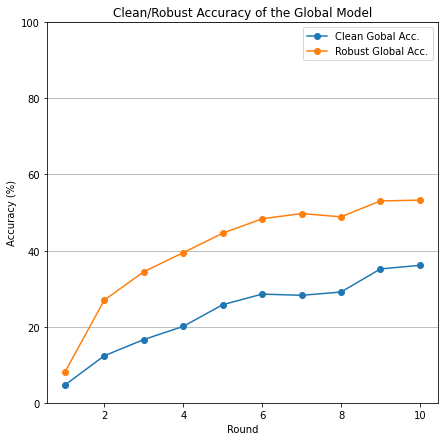

In [43]:
# global_acc_list = [26.716984038791264, 60.15311546396437, 73.3554127190271, 77.58730917267368, 80.73023665495782, 80.09354952848075,  81.32439079295223]

import matplotlib.pyplot as plt

num_round_list = list(range(1, num_rounds+1))

ymin = 0
ymax = 100

plt.figure(figsize=(7, 7))
plt.grid(axis='y')
plt.gca().set_ylim([ymin, ymax])
plt.title("Clean/Robust Accuracy of the Global Model")
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")

plt.plot(num_round_list, glob_acc_list, '-o', label='Clean Gobal Acc.')
plt.plot(num_round_list, robust_acc_list, '-o', label='Robust Global Acc.')
plt.legend()

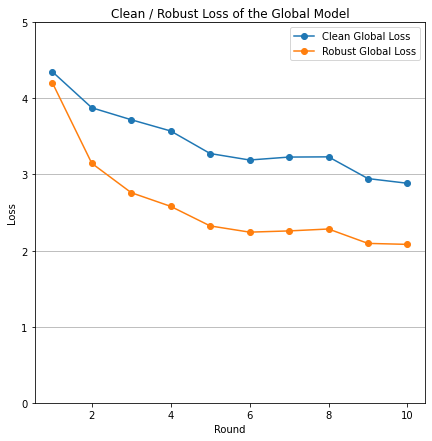

In [44]:
import matplotlib.pyplot as plt

num_round_list = list(range(1, num_rounds+1))

ymax = 5
ymin = 0

plt.figure(figsize=(7, 7))
plt.grid(axis='y')

plt.gca().set_ylim([ymin, ymax])
plt.title("Clean / Robust Loss of the Global Model")
plt.xlabel("Round")
plt.ylabel("Loss")

plt.plot(num_round_list, glob_loss_list, '-o', label='Clean Global Loss')
plt.plot(num_round_list, robust_loss_list, '-o', label='Robust Global Loss')
plt.legend()

In [45]:
# import matplotlib.pyplot as plt

# total_iter_per_client = num_local_epochs * num_rounds
# client_id_list = list(range(0, num_clients))
# total_iter_list = list(range(1, total_iter_per_client+1))

# plt.figure(figsize=(7, 7))
# plt.grid(axis='y')
# plt.title("Average Loss of each client")
# plt.xlabel("Iteration")
# plt.ylabel("Loss of each client")

# for client_id in client_id_list:
#     plt.plot(total_iter_list, id_loss_dict[client_id], label=("Client_id={}".format(client_id)))
#     plt.legend()

In [46]:
# import matplotlib.pyplot as plt

# total_iter_per_client = num_local_epochs * num_rounds
# client_id_list = list(range(0, num_clients))
# total_iter_list = list(range(1, total_iter_per_client+1))

# plt.figure(figsize=(7, 7))
# plt.grid(axis='y')
# plt.title("Average Accuracy of each client")
# plt.xlabel("Num rounds")
# plt.ylabel("Accuracy (%)")

# for client_id in client_id_list:
#     plt.plot(total_iter_list, id_acc_dict[client_id], label=("Client_id={}".format(client_id)))
#     plt.legend()

## 5.1 Global Accuracy per Each Proportion

In [47]:
# import matplotlib.pyplot as plt

# total_num_client = [5, 10, 15, 20]
# glob_acc_list = [82.5, 79.6, 73.2, 70.0]

# ymax = 100
# ymin = 0
# xmax = 21
# xmin = 5

# plt.figure(figsize=(7, 7))
# plt.grid(axis='y')

# plt.gca().set_xlim([xmin, xmax])
# plt.gca().set_ylim([ymin, ymax])
# plt.title("Global Accuracy when 80% of Clients Chosen Every Round")
# plt.xlabel("Total No. of Clients")
# plt.ylabel("Global Accuracy (%)")

# plt.plot(total_num_client, glob_acc_list, '-o')
# plt.legend()

In [48]:
# import matplotlib.pyplot as plt

# total_num_client = [6, 8, 16, 20]
# glob_acc_list = [78.6, 76.1, 61.5, 57.0]

# ymax = 100
# ymin = 0

# xmax = 21
# xmin = 5

# plt.figure(figsize=(7, 7))
# plt.grid(axis='y')

# plt.gca().set_xlim([xmin, xmax])
# plt.gca().set_ylim([ymin, ymax])
# plt.title("Global Accuracy when 50% of Clients Chosen Every Round")
# plt.xlabel("Total No. of Clients")
# plt.ylabel("Global Accuracy (%)")

# plt.plot(total_num_client, glob_acc_list, '-o')
# plt.legend()

In [49]:
# import matplotlib.pyplot as plt

# total_num_client = [5, 10, 15, 20]
# glob_acc_list = [71.8, 48.5, 40.8, 34.1]

# ymax = 100
# ymin = 0

# xmax = 21
# xmin = 5

# plt.figure(figsize=(7, 7))
# plt.grid(axis='y')

# plt.gca().set_ylim([xmin, xmax])
# plt.gca().set_ylim([ymin, ymax])
# plt.title("Global Accuracy when 20% of Clients Chosen Every Round")
# plt.xlabel("Total No. of Clients")
# plt.ylabel("Global Accuracy (%)")

# plt.plot(total_num_client, glob_acc_list, '-o')
# plt.legend()

## 6. Standard and Robust Accuracy

### 6.1 Standard Accuracy

In [50]:
# atk = FGSM(model, eps=8/255)
torch.cuda.empty_cache()
global_model.eval()
criterion = nn.CrossEntropyLoss()

total = 0
glob_loss = 0
glob_acc = 0
correct = 0

tq_batch = tqdm(test_loader, total=len(test_loader), leave=False)
for images, labels in tq_batch:
    images = images.to(device)
    labels = labels.to(device)

    outputs = global_model(images)
    loss = criterion(outputs, labels)
    glob_loss += loss.item()

    _, preds = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (preds == labels).sum()

    glob_acc += float(correct) / total
    batch_acc = float(correct) / total

    tq_batch.set_postfix_str('Global loss = {:.4f} ; Global acc = {:.4f} '.format(loss.item(), batch_acc))

# Average global loss and acc of the batch
glob_loss = glob_loss / len(test_loader)
glob_acc = glob_acc / len(test_loader)

print("Global loss: ", glob_loss)
print("Global accuracy: {} %".format(glob_acc*100))

  0%|          | 0/83 [00:00<?, ?it/s]

Global loss:  3.496690572026264
Global accuracy: 24.941948411848198 %


### 6.2 Robust Accuracy

In [51]:
# white_model = white_box_model(num_classes=num_classes).to(device)
white_model = models.alexnet(pretrained=True).to(device)

atk_list = [
    FGSM(white_model, eps=8/255),
#     BIM(white_model, eps=8/255, alpha=100, steps=100),
#     RFGSM(white_model, eps=8/255, alpha=2/255, steps=100),
#     CW(white_model, c=1, lr=0.01, steps=100, kappa=0),
#     PGD(white_model, eps=8/255, alpha=2/225, steps=10, random_start=True),
#     PGDL2(white_model, eps=1, alpha=0.2, steps=100),
#     EOTPGD(white_model, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
    FFGSM(white_model, eps=8/255, alpha=10/255), # *
#     TPGD(white_model, eps=8/255, alpha=2/255, steps=100),
#     MIFGSM(white_model, eps=8/255),
#     VANILA(white_model),
#     FAB(white_model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
#     FAB(white_model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
    Square(white_model, eps=8/255, n_queries=2000, n_restarts=1, loss='ce'), # *
#     OnePixel(white_model, pixels=5, inf_batch=50),
#     DeepFool(white_model, steps=10),
#     DIFGSM(white_model, eps=8/255, alpha=2/255, steps=10, diversity_prob=0.5, resize_rate=0.9)
#     DIFGSM(white_model, eps=8/255)
]

torch.cuda.empty_cache()
global_model.eval()
criterion = nn.CrossEntropyLoss()

total = 0
glob_loss = 0
glob_acc = 0
correct = 0

# tq_batch = tqdm(test_loader, total=len(test_loader))

for atk in tqdm(atk_list):
    print("")
    print("*"*100)
    print(atk)
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Attack the model
        images = atk(images, labels)

        outputs = global_model(images)
        loss = criterion(outputs, labels)
        glob_loss += loss.item()

        _, preds = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (preds == labels).sum()

        glob_acc += float(correct) / total
        batch_acc = float(correct) / total

        # tq_batch.set_postfix_str('Robust loss = {:.4f} ; Robust acc = {:.4f} '.format(loss.item(), batch_acc))

    # Average global loss and acc of the batch
    glob_loss = glob_loss / len(test_loader)
    glob_acc = glob_acc / len(test_loader)
    
    print("Robust loss: ", glob_loss)
    print("Robust accuracy: {}%".format(glob_acc*100))
    print("*"*100)
    print("")

  0%|          | 0/3 [00:00<?, ?it/s]


****************************************************************************************************
FGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, attack_mode=default, return_type=float)


  0%|          | 0/83 [00:00<?, ?it/s]

Robust loss:  1.2103499522410244
Robust accuracy: 70.28688212009926%
****************************************************************************************************


****************************************************************************************************
FFGSM(model_name=AlexNet, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)


  0%|          | 0/83 [00:00<?, ?it/s]

Robust loss:  1.2140373390728718
Robust accuracy: 70.48033066667759%
****************************************************************************************************


****************************************************************************************************
Square(model_name=AlexNet, device=cuda:0, norm=Linf, n_queries=2000, eps=0.03137254901960784, p_init=0.8, n_restarts=1, seed=0, verbose=False, loss=ce, rescale_schedule=True, attack_mode=default, return_type=float)


  0%|          | 0/83 [00:00<?, ?it/s]

Robust loss:  3.523051924497026
Robust accuracy: 61.754879546287945%
****************************************************************************************************

